In [4]:
import os
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import face_recognition

IMAGE_CACHE = 'image_features_cache.pkl'
FACE_CACHE = 'face_features_cache.pkl'

In [5]:
class FaceRecognition:
    """Class for handling face recognition."""

    @staticmethod
    def extract_face_features(image_path):
        """Extract face features from an image."""
        try:
            image = face_recognition.load_image_file(image_path)
            face_encodings = face_recognition.face_encodings(image)
            return face_encodings  # Return a list of face encodings
        except Exception as e:
            print(f"Error extracting face features for {image_path}: {e}")
            return None

In [6]:
class ImageRecognition:
    """Class for handling image detection using YOLOv4."""

    def __init__(self, model_weights='yolov4.weights', config_file='yolov4.cfg', classes_file='coco.names'):
        self.net = cv2.dnn.readNet(model_weights, config_file)
        self.layer_names = self.net.getLayerNames()
        unconnected_out_layers = self.net.getUnconnectedOutLayers().flatten()
        self.output_layers = [self.layer_names[i - 1] for i in unconnected_out_layers]
        with open(classes_file, "r") as f:
            self.classes = [line.strip() for line in f.readlines()]

    def load_and_preprocess_image(self, image_path):
        """Load and preprocess the image for YOLO detection."""
        img = cv2.imread(image_path)
        height, width, _ = img.shape
        blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
        return blob, img, width, height

    def extract_objects(self, blob, confidence_threshold, image_width, image_height):
        """Extract features using YOLO (bounding boxes, class IDs, and confidence scores)."""
        self.net.setInput(blob)
        outputs = self.net.forward(self.output_layers)
        
        bounding_boxes = []
        class_ids = []
        confidences = []
        
        for output in outputs:
            for detection in output:
                scores = detection[5:]  # Assuming scores start from the 6th element
                class_id = np.argmax(scores)  # Get the index of the highest score
                confidence = scores[class_id]  # Get the maximum score
                
                if confidence > confidence_threshold:  # Apply confidence threshold
                    # Extract bounding box coordinates
                    x_center = int(detection[0] * image_width)
                    y_center = int(detection[1] * image_height)
                    width = int(detection[2] * image_width)
                    height = int(detection[3] * image_height)
                    
                    # Calculate the top-left corner of the bounding box
                    x = int(x_center - width / 2)
                    y = int(y_center - height / 2)
                    
                    # Append to respective lists
                    bounding_boxes.append([x, y, width, height])
                    class_ids.append(class_id)
                    confidences.append(confidence)
        return bounding_boxes, class_ids, confidences

In [20]:

class ImageSearchEngine:
    """Class for searching similar images based on the query."""

    def __init__(self, folder_path, general_model, thres, class_file='coco.names'):
        self.folder_path = folder_path
        self.general_model = general_model
        self.confidence_threshold = thres
        self.class_file = class_file
        self.classes = []
        with open(class_file, 'r') as f:
            self.classes = [line.strip() for line in f.readlines()]
        self.folder_image_features = self._load_or_extract_objects()

    def _load_or_extract_objects(self):
        """Load cached features if they exist, otherwise extract and cache them."""
        image_features = {}

        # Load cached features if the cache file exists
        if os.path.exists(IMAGE_CACHE):
            with open(IMAGE_CACHE, 'rb') as f:
                image_features = pickle.load(f)

        cached_images = set(image_features.keys())

        all_images = [img for img in os.listdir(self.folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
        print(f"Found {len(all_images)} images in the folder.")

        new_images = [img for img in all_images if img not in cached_images]

        for img in new_images:
            img, features = self.detect_objects(img)
            if features:
                image_features[img] = features

        # Cache the extracted features
        with open(IMAGE_CACHE, 'wb') as f:
            pickle.dump(image_features, f)
       
        return image_features

    def detect_objects(self, img):
        """Extract features for a single image and plot the image with bounding boxes."""
        img_path = os.path.join(self.folder_path, img)
        im = cv2.imread(img_path)

        if im is not None:
            height, width = im.shape[:2]

            blob, _, _, _ = self.general_model.load_and_preprocess_image(
                img_path)

            bounding_boxes, class_ids, confidences = self.general_model.extract_objects(
                blob, self.confidence_threshold, width, height)

            if bounding_boxes and class_ids and confidences:
                features = []
                for bbox, cls_id, conf in zip(bounding_boxes, class_ids, confidences):
                    features.append({
                        'bounding_box': bbox,
                        'class_id': cls_id,
                        'confidence': conf
                    })

                return img, features

        return img, None

    def plot_image_with_boxes(self, filename, features):
        """Plot a single image with bounding boxes."""
        img_path = os.path.join(self.folder_path, filename)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.axis('off')

        for feature in features:
            bbox = feature['bounding_box']
            x, y, w, h = bbox
            plt.gca().add_patch(plt.Rectangle((x, y), w, h, edgecolor='red', linewidth=2, fill=False))

        plt.title(filename)
        plt.show()

    def search_images_by_query(self, query):
        """Search for similar images based on the user query."""
        # Convert query to lowercase
        query = query.lower()

        # Try to find the class ID for the query
        try:
            target_id = self.classes.index(query)
        except ValueError:
            print(f"Query '{query}' not found in COCO names. More training needed.\n")
            return []

        # Find images that contain the queried object class
        matching_images = []
        for filename, features in self.folder_image_features.items():
            for feature in features:
                if feature['class_id'] == target_id:
                    matching_images.append(filename)
                    break  # No need to check other features of this image

        return matching_images


In [21]:
class FaceSearchEngine:
    """Class for searching images containing specific faces."""

    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.face_features_cache = self._load_or_extract_face_features()

    def _load_or_extract_face_features(self):
        """Load cached face features if they exist, otherwise extract and cache them."""
        face_features = {}

        if os.path.exists(FACE_CACHE):
            with open(FACE_CACHE, 'rb') as f:
                face_features = pickle.load(f)

        cached_images = set(face_features.keys())

        all_images = [img for img in os.listdir(self.folder_path) if img.endswith(('.png', '.jpg', '.jpeg'))]
        print(f"Found {len(all_images)} images in the folder.")

        new_images = [img for img in all_images if img not in cached_images]

        for img in new_images:
            print(f"Extracting face features for {img}")
            img_path = os.path.join(self.folder_path, img)
            encodings = FaceRecognition.extract_face_features(img_path)
            face_features[img] = encodings   # store the encodings in the cache even the empty ones

        with open(FACE_CACHE, 'wb') as f:
            pickle.dump(face_features, f)

        return face_features

    def search_images_by_face(self, input_image_path):
        """Search for images containing faces from the input image."""
        input_encodings = FaceRecognition.extract_face_features(input_image_path)
        
        # Check if any encodings were found in the input image
        if not input_encodings:
            print("No faces found in the input image.")
            return []
    
        matching_images = []
        
        for img, encodings in self.face_features_cache.items():
            # Compare each encoding in the cached encodings with the input encodings
            for encoding in encodings:
                matches = face_recognition.compare_faces(input_encodings, encoding, tolerance=0.7)
                if any(matches):  # If there's a match with any of the faces
                    matching_images.append(img)
                    break  # No need to check more encodings for this image
    
        return matching_images


In [22]:
def plot_matching_images(matching_images, intent, folder_path, input_image_path=None):
        """Plot the input image along with the matching images found."""
        plt.figure(figsize=(12, 8))

        if intent == 'face':
            # Plot the input image
            plt.subplot(1, len(matching_images) + 1, 1)
            input_image = Image.open(input_image_path)
            plt.imshow(input_image)
            plt.axis('off')  # Hide axes
            plt.title("Input Image")
                   

        # Plot matching images
        for i, result in enumerate(matching_images):
            plt.subplot(1, len(matching_images) + 1, i + 2)
            img_path = os.path.join(folder_path, result)
            img = Image.open(img_path)
            plt.imshow(img)
            plt.axis('off')  # Hide axes
            plt.title(f"Match {i + 1}")

        plt.show()

Found 16 images in the folder.
Matching Images: ['1685421488_keanu-reeves.jpg', 'gettyimages-1394407503-612x612.jpg', 'gettyimages-534354328-612x612.jpg', 'john-wick-art-l3.jpg', 'qVS4Y3emBIfxqvlTFjFZOFb4kkK.jpg']


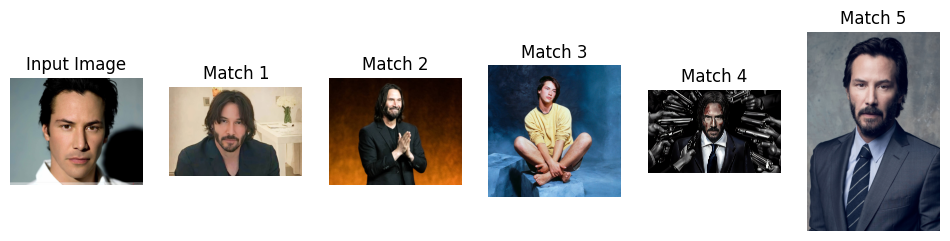

In [24]:
import dotenv
dotenv.load_dotenv()

if __name__ == "__main__":
   
    folder_path = os.getenv("FOLDER_PATH")

    intent = input("Enter your intent (face/image): ")
    if intent == "image":
        general_model = ImageRecognition()
        image_search_engine = ImageSearchEngine(folder_path=folder_path, general_model=general_model, thres=0.8)

        query = input("Enter your search query (one word): ")

        search_results = image_search_engine.search_images_by_query(query)
        print("Search Results:", search_results)

        # Plotting search results
        if search_results:  # Check if there are results
            plot_matching_images(search_results, intent, folder_path)
        else:
            print("No search results found.")

    elif intent == "face":
        face_search_engine = FaceSearchEngine(folder_path=folder_path)

        input_image_path = input("Enter the path to the input image: ")
        matching_images = face_search_engine.search_images_by_face(input_image_path)
        print("Matching Images:", matching_images)

        # Plotting matching images
        if matching_images:  # Check if there are matching images
            plot_matching_images(matching_images, intent, folder_path, input_image_path)
        else:
            print("No matching images found.")


